In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import tensorflow as tf ; 
import re ; 
import os ;
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/amazon-product-length-prediction-dataset/dataset/sample_submission.csv
/kaggle/input/amazon-product-length-prediction-dataset/dataset/train.csv
/kaggle/input/amazon-product-length-prediction-dataset/dataset/test.csv


In [2]:
BATCH_SIZE = 512
train_ds = tf.data.experimental.make_csv_dataset(
    "/kaggle/input/amazon-product-length-prediction-dataset/dataset/train.csv",
    batch_size=BATCH_SIZE,
    num_epochs=1 , 
    prefetch_buffer_size=1024,
    ignore_errors=tf.data.Dataset.ignore_errors , 
    select_columns=['TITLE','BULLET_POINTS','DESCRIPTION','PRODUCT_LENGTH'],
    label_name='PRODUCT_LENGTH',
    num_parallel_reads=10,

)
for features , labels in train_ds.take(1) :
    for key , value in features.items():
        print(f"{key} : {value}")
    print("Length" , labels.numpy())

TITLE : [b'Four Seasons 56651 Hose Assembly'
 b"Good Luck Sock Women's Flying Insects Socks - Red, Adult Shoe Size 5-9"
 b'VMS INDIA Cartoon Flower Pots Decoration Ceramic Plant Pots for Desktop Home Office Girl'
 b'Zitrades Baby Night Light Projector Party Constellation Laser Lights Lamp Color Changing Indoor Lighting for Kids Room Children Bedroom with Speakers Nursery Decor Decorative Sleep Mood Light'
 b'ASHVAH Customized Shailaja Name Ceramic Coffee Mug - Best Birthday Gift for Daughter, Son, Sister, Brother, Return Gift for Kids, Name -Shailaja'
 b'Dinglijia Designed for iPhone 13 Mini Case 5.4 Inch, Military Grade Shockproof Protection, Drop-Tested Cover and Camera Lens Protection Shiled Phone Case for iPhone 13 Mini(5.4) HD Gray'
 b'Isolate It!: Sorbothane Acoustic and Vibration Thin Film Square (0.080 x 6 x 6") with 3M Adhesive 60 Duro - 1 Sheet'
 b"PUMA Golf 2020 Women's Mesh 1/4 Zip, PUMA Black, XX-Large"
 b'3D MAXpider Custom Fit Kagu Floor Mat (Black) for 2020-2022 Tesla M

PREPROCESSING FEATURES 

    -REMOVING HTML

    -REMOVING PANTUATIONS

    -REMOVING CONTROL CHARACTERS 
    
    -REPLACING NEW LINES WITH EMPTY SPACES

FEATURE ENGINEERING

In [3]:
def flatten_columns(features, label):
    # Join the TITLE, BULLET_POINTS, and DESCRIPTION columns into a single string
    text = tf.strings.join([features['TITLE'], features['BULLET_POINTS'], features['DESCRIPTION']], separator=' ')
    # Removing HTML from text 
    text = tf.strings.regex_replace(text,"<[^>]+>", " ")
    # Convert the string to lowercase
    text = tf.strings.lower(text)
    # Replace any newline characters with spaces
    text = tf.strings.regex_replace(text, '\n', ' ')
    #Removing Control Character
    text = tf.strings.regex_replace(text, "[^\w\s]", " ")
    # label = 1/(label+1);
    # Return the flattened text and the label
    return  text, label
train_ds = train_ds.map(flatten_columns)
for x in train_ds.take(1):
    print(x)

(<tf.Tensor: shape=(512,), dtype=string, numpy=
array([b'3d maxpider custom fit kagu floor mat  black  for 2020 2022 tesla model 3   1st row 2nd row  all weather protection   the 3d maxpider kagu series floor liners are designed to provide complete automotive interior protection for your vehicle from dirt  mud  salt  rain  snow and keep your vehicle floor clean and pristine in all seasons  the perfect fit   using high precision 3d laser scanning technology  each floor mat is custom made for your vehicle with maximum accuracy and coverage compared to oem and universal car mats  the raised side walls provide seamless edge to edge protection and prevent dirt from getting on your vehicle carpet  multi layer construction   the innovative hybrid material floor liners offer many greater benefits than traditional car mats  the thermoplastic rubber surface offers waterproof protection and complements your vehicle interior with a sleek modern texture  the lightweight xpe foam middle layer absorb

TOKENIZATION OF FEATURES

In [4]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200
train_int_vectorization = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                                        output_mode='int',
                                                        output_sequence_length=MAX_SEQUENCE_LENGTH);
train_text_dataset =train_ds.map(lambda text,labels: text)
train_int_vectorization.adapt(train_text_dataset);
def train_int_vecotrize_text(text,label):
    text = tf.expand_dims(text,-1);
    return train_int_vectorization(text) , label ; 

MAPING TRAIN DATASET TO THEIR INTEGER VECTORIZED FORM

In [5]:
featurs , label = train_ds.as_numpy_iterator().next()
first_text , first_label = featurs[1] , label[1] ; 
print("Feature" , first_text);
print("Label",first_label)
print("'int' vectorized Feature : ",train_int_vecotrize_text(first_text, first_label)[0])
train_ds = train_ds.map(train_int_vecotrize_text);

Feature b'reiko belt clip polymer case for blackberry bb9900   retail packaging   hot pink  belt clip polymer case for blackberry bold 9900 hot pink belt clip polymer case polymer case  belt clip polymer case for blackberry bold 9900 hot pink'
Label 210.0
'int' vectorized Feature :  tf.Tensor(
[[   1  621  977 2752   38    4    1    1 2534  753  504  427  621  977
  2752   38    4    1 2005    1  504  427  621  977 2752   38 2752   38
   621  977 2752   38    4    1 2005    1  504  427    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0 

SPLITING DATASET TO TRAIN AND VALIDATION

In [6]:
dataset_size = 2249698
train_percent = 0.7
train_size =int(int(dataset_size * train_percent)/BATCH_SIZE) ;
validation_size = dataset_size - train_size
train = train_ds.take(train_size)
val = train_ds.skip(train_size)
del train_ds

MAKING REGRESSION MODEL AND SETTING LAST LAYER ACTIVATION AS RELU since LENGHT IS ALWAYS POSITIVIE

In [7]:
checkpoints = tf.keras.callbacks.ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

def create_model(vocab_size , num_labels):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(100,activation="relu"),
        tf.keras.layers.Dense(50,activation="relu"),
        tf.keras.layers.Dense(20,activation="relu"),
        tf.keras.layers.Dense(num_labels,activation="relu")
        
    ])
    return model
model = create_model(vocab_size=VOCAB_SIZE+1 , num_labels=1)
model.compile(loss=tf.keras.losses.mean_absolute_error,optimizer='adam',metrics=['mse'])

history = model.fit(train,validation_data=val , epochs=10,callbacks=[checkpoints])

Epoch 1/10
3075/3075 [==============================] - 132s 43ms/step - loss: 3887.9497 - mse: 2444384534528.0000 - val_loss: 3249.4705 - val_mse: 387801055232.0000
Epoch 2/10
3075/3075 [==============================] - 130s 42ms/step - loss: 3878.0432 - mse: 2444384010240.0000 - val_loss: 3251.4929 - val_mse: 387947823104.0000
Epoch 3/10
3075/3075 [==============================] - 130s 42ms/step - loss: 3852.2820 - mse: 2444383748096.0000 - val_loss: 3223.3782 - val_mse: 387905421312.0000
Epoch 4/10
3075/3075 [==============================] - 131s 42ms/step - loss: 3838.0090 - mse: 2444382961664.0000 - val_loss: 3209.9890 - val_mse: 387801743360.0000
Epoch 5/10
3075/3075 [==============================] - 130s 42ms/step - loss: 3830.6396 - mse: 2444383485952.0000 - val_loss: 3205.8066 - val_mse: 387820421120.0000
Epoch 6/10
3075/3075 [==============================] - 109s 35ms/step - loss: 3823.1809 - mse: 2444375359488.0000 - val_loss: 3195.7383 - val_mse: 387801055232.0000
Epoc

MAKING GRAPH OF VALIDATION VS EPOCHS

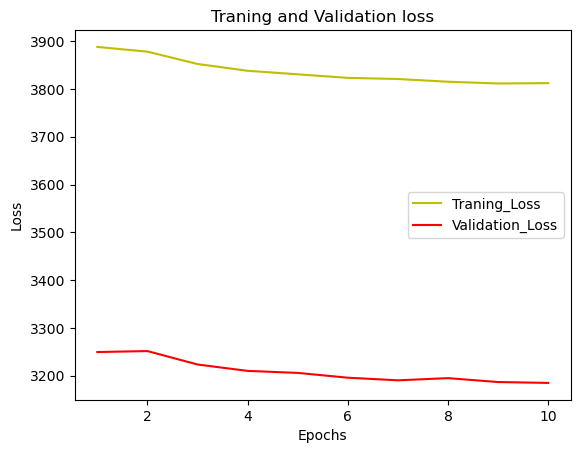

In [8]:
from matplotlib.pyplot import plot , xlabel , ylabel , legend ,show ,title ;
loss = history.history['loss']
val_loss = history.history['val_loss'];
epochs = range(1,len(loss)+1);
plot(epochs ,loss , 'y',label='Traning_Loss');
plot(epochs , val_loss , 'r' , label = 'Validation_Loss')
title("Traning and Validation loss") 
xlabel('Epochs')
ylabel('Loss')
legend()
show()